In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
dataDir = './Nutrient'
train_dir = os.path.join(dataDir, 'train')
val_dir = os.path.join(dataDir, 'val')
test_dir = os.path.join(dataDir, 'test')

In [18]:
BATCH_SIZE = 32
NUM_CLASSES = 4

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=0.2,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(224, 224),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                 target_size=(224, 224),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(224, 224),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

Found 1146 images belonging to 4 classes.
Found 268 images belonging to 4 classes.
Found 70 images belonging to 4 classes.


In [ ]:
labels = list(train_generator.class_indices.keys())

print(labels)

['Healthy', 'Kalium_Deficiency', 'Nitrogen_Deficiency', 'Phosphorus_Deficiency']


In [20]:
print("Number of Health Plants:",len(os.listdir(dataDir + '/train/Healthy' )))
print("Number of Kalium Deficiency:",len(os.listdir(dataDir + '/train/Kalium_Deficiency')))
print("Number of Nitrogen Deficiency:",len(os.listdir(dataDir + '/train/Nitrogen_Deficiency')))
print("Number of Phosphorus Deficiency:",len(os.listdir(dataDir + '/train/Phosphorus_Deficiency')))

Number of Health Plants: 301
Number of Kalium Deficiency: 255
Number of Nitrogen Deficiency: 355
Number of Phosphorus Deficiency: 235


In [21]:
def show_image_samples(gen):
    # Ensure the generator has class_indices attribute
    if hasattr(gen, 'class_indices'):
        test_dict = gen.class_indices
        classes = list(test_dict.keys())
    else:
        raise AttributeError("The provided generator does not have 'class_indices' attribute.")

    images, labels = next(gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)  # show a maximum of 25 images

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image, cmap='gray')
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, fontsize=16)
        plt.axis('off')

    plt.show()

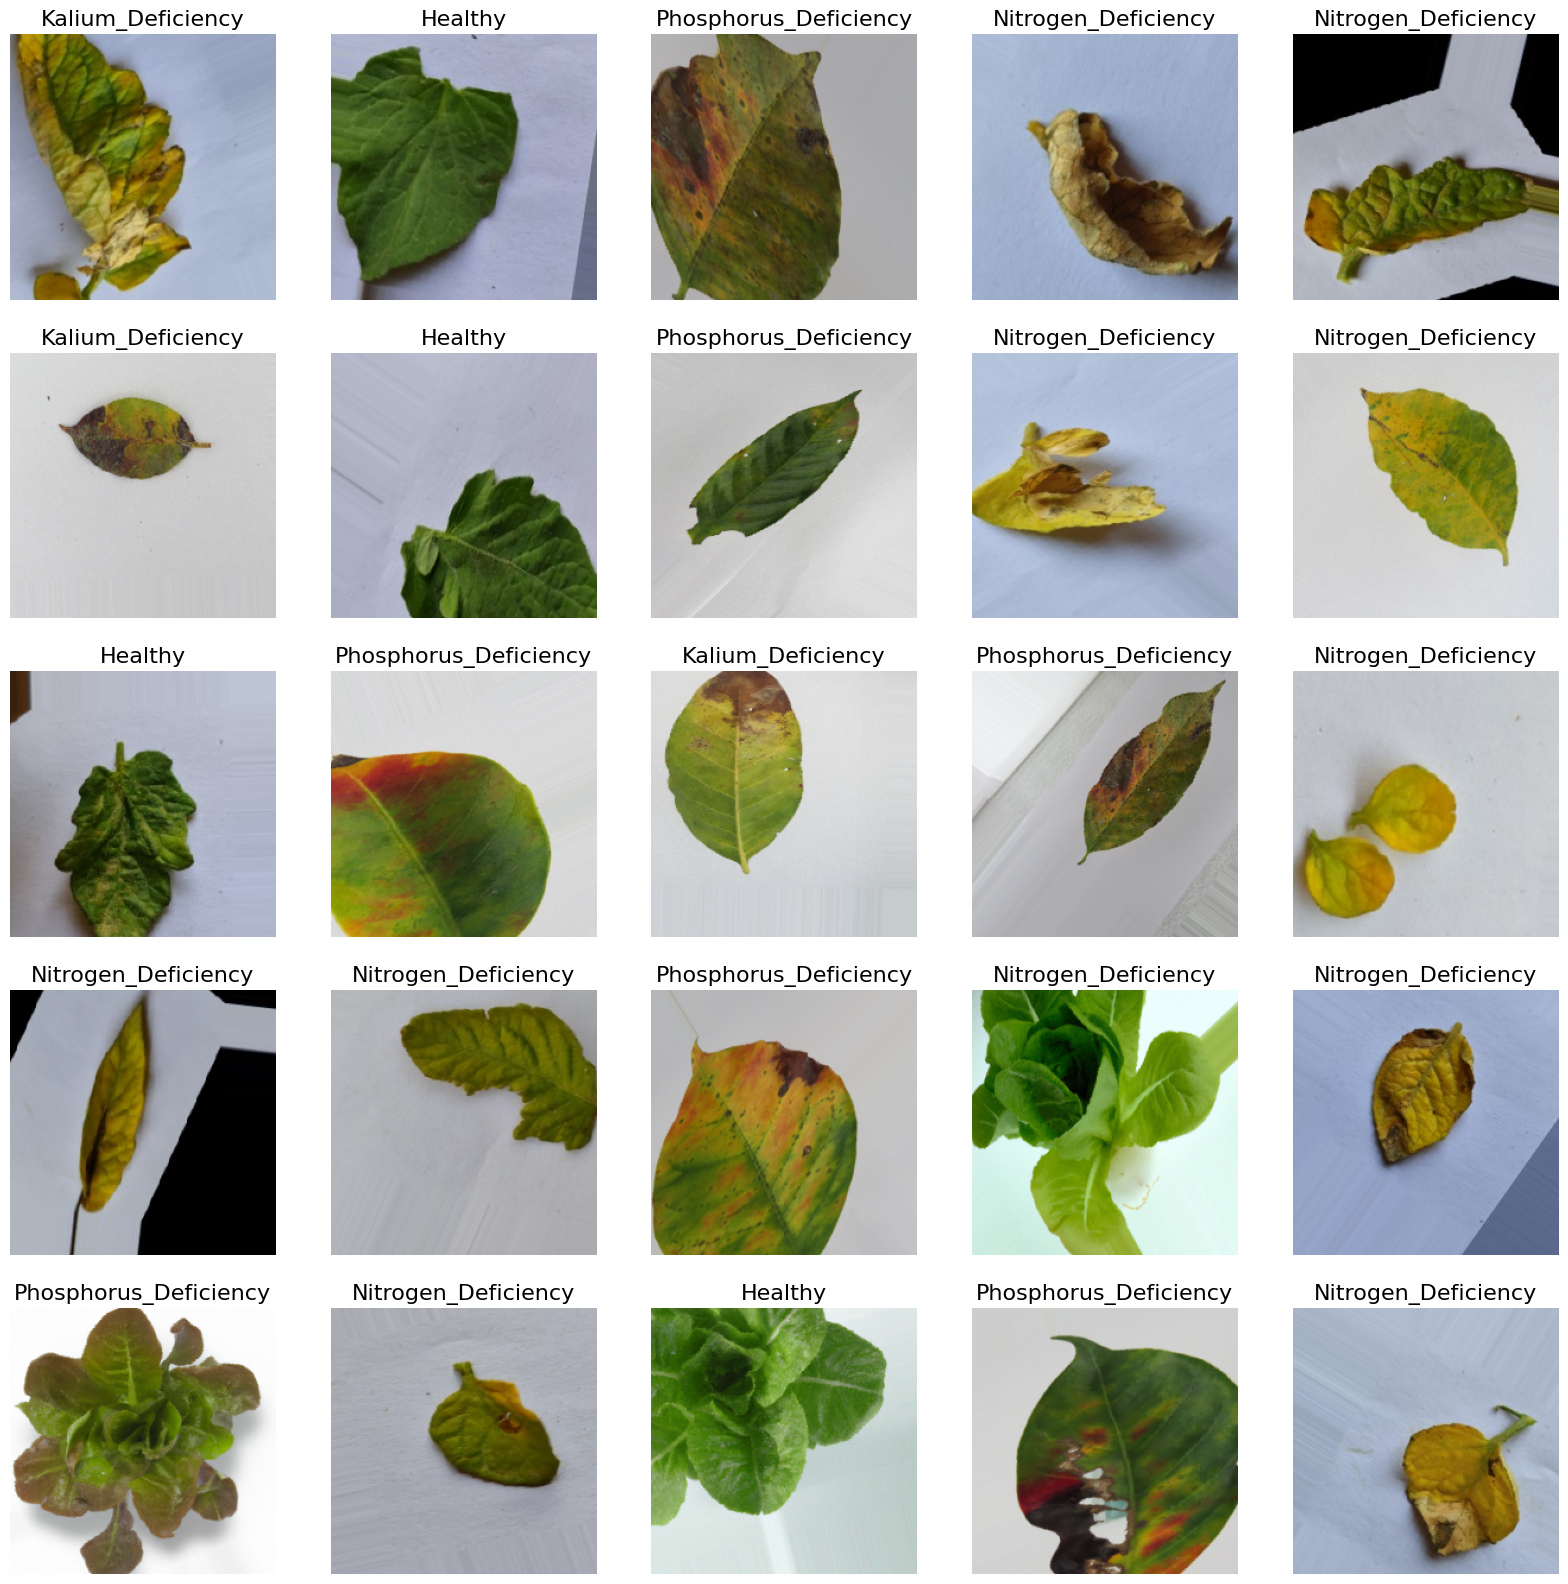

In [22]:
show_image_samples(train_generator)

In [23]:
pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = False

In [24]:
model = Sequential([
      pretrained_model,
      GlobalAveragePooling2D(),
      Dense(512, activation='relu'),
      BatchNormalization(),
      Dropout(.3),
      Dense(NUM_CLASSES, activation='softmax')
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [25]:
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
EPOCHS = 15

In [27]:
history = model.fit(train_generator,
                      epochs=EPOCHS,
                      validation_data=val_generator,
                      verbose=1, 
                      batch_size=BATCH_SIZE,
                      callbacks=[lr_scheduler])

Epoch 1/15


36/36 [==============================] - 86s 2s/step - loss: 0.8409 - accuracy: 0.7129 - val_loss: 0.8231 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 2/15
36/36 [==============================] - 69s 2s/step - loss: 0.4104 - accuracy: 0.8560 - val_loss: 0.5595 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 3/15
36/36 [==============================] - 70s 2s/step - loss: 0.3498 - accuracy: 0.8787 - val_loss: 0.5080 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 4/15
36/36 [==============================] - 69s 2s/step - loss: 0.2962 - accuracy: 0.8874 - val_loss: 0.4567 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 5/15
36/36 [==============================] - 70s 2s/step - loss: 0.2613 - accuracy: 0.9058 - val_loss: 0.4857 - val_accuracy: 0.8396 - lr: 0.0010
Epoch 6/15
36/36 [==============================] - 69s 2s/step - loss: 0.2734 - accuracy: 0.9049 - val_loss: 0.3881 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 7/15
36/36 [==============================] - 68s 2s/step - loss: 0.2114 -

In [28]:
def plot_images(history):
  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], label='Train accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label='Train loss')
  plt.plot(history.history['val_loss'], label='Val loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

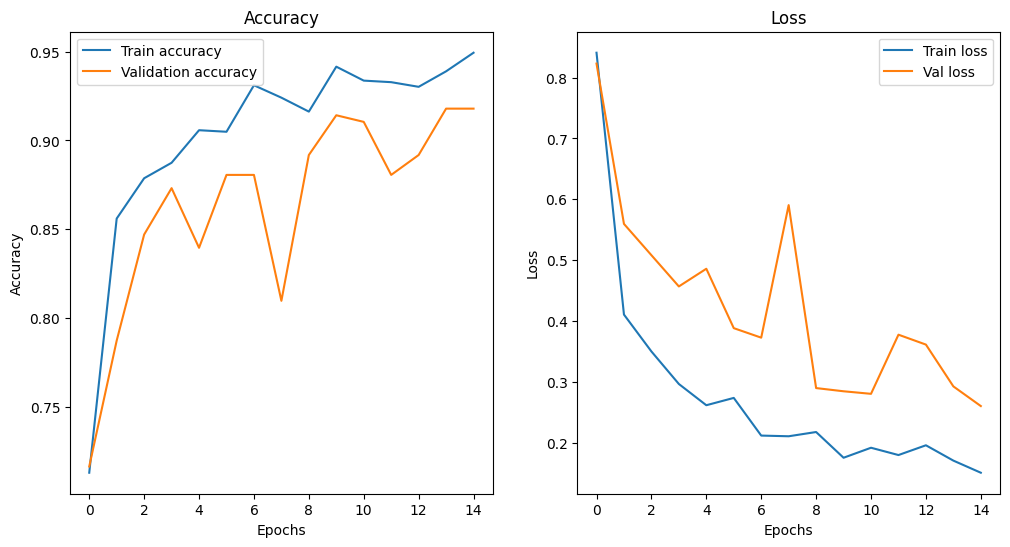

In [29]:
plot_images(history)

### Evaluate Model

In [30]:
test_generator.reset()

loss, acc =  model.evaluate(test_generator)

print(f'Accuracy in test data: {acc:.2%}')
print(f'Loss in test data: {loss:.2%}')

3/3 [==============================] - 2s 638ms/step - loss: 0.4075 - accuracy: 0.8714
Accuracy in test data: 87.14%
Loss in test data: 40.75%


In [31]:
test_generator.reset()
test_predict = model.predict(test_generator)
y_pred = np.argmax(test_predict,axis=1)
y_pred

3/3 [==============================] - 4s 604ms/step


array([2, 3, 3, 0, 0, 0, 3, 3, 0, 2, 0, 2, 1, 0, 3, 3, 0, 1, 0, 0, 3, 1,
       3, 2, 1, 2, 2, 3, 1, 2, 3, 3, 1, 1, 3, 1, 2, 3, 3, 3, 0, 1, 3, 3,
       0, 1, 3, 3, 0, 2, 0, 0, 2, 2, 3, 2, 3, 3, 0, 2, 1, 3, 2, 0, 1, 3,
       3, 2, 0, 0], dtype=int64)

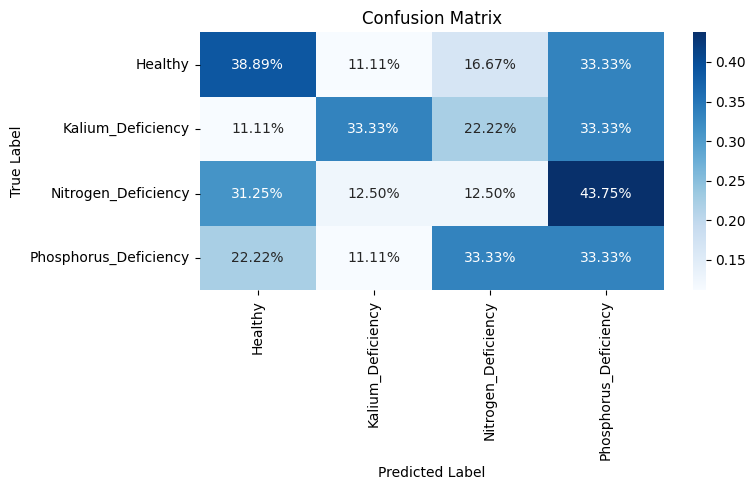

In [32]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 5))
sns.heatmap(cm_normalized,
            annot=True,  
            fmt='.2%',   
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix')
plt.ylabel('True Label')      
plt.xlabel('Predicted Label') 
plt.tight_layout()
plt.show()


### Manual Test

In [53]:
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.models import load_model

In [75]:
model_dir = 'model/nutrient.h5'
img_dir = 'E:/Bangkit/Capstone/HidroQu/images.jpg'

In [76]:
def preprocess_img(img):
  img = img_to_array(img)
  img_normalized = img / 255.0
  img_expanded = np.expand_dims(img_normalized, axis=0)
  return img_expanded 

def predict_img(img):
  model_load = load_model(model_dir)
  predict_img = model_load.predict(img)
  
  predict = model.predict(img)
  
  result_model_load = np.argmax(predict_img)
  result = np.argmax(predict)
  
  return labels[result], labels[result_model_load] 

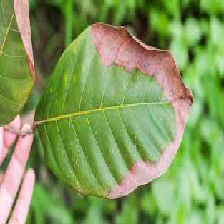

In [77]:
image = load_img(img_dir, target_size=(224, 224))
image

In [78]:
image_clean=preprocess_img(image)

In [79]:
asli, load =predict_img(image_clean)

print(f'Hasil pakai model trained {asli}')
print(f'Hasil pakai model load {load}')

1/1 [==============================] - 0s 49ms/step
Hasil pakai model trained Phosphorus_Deficiency
Hasil pakai model load Phosphorus_Deficiency


In [74]:
# model.save('nutrient.h5')